# Technical Analysis
* Stock Chart Plotting With Period Control (daily, weekly)
* Simple Moving Average Analysis
* Bollinger Band Analysis
* RSI Analysis
* MACD Analysis

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

### Technical Indicators

In [2]:
def calculate_sma(data, window):
    return data['Adj Close'].rolling(window=window).mean()

def calculate_bollinger_bands(data, window, num_std_dev):
    sma = calculate_sma(data, window)
    rolling_std = data['Adj Close'].rolling(window=window).std()
    upper_band = sma + (num_std_dev * rolling_std)
    lower_band = sma - (num_std_dev * rolling_std)

    # Generate buy/sell signals based on Bollinger Bands
    buy_signal = data['Adj Close'] < lower_band
    sell_signal = data['Adj Close'] > upper_band

    result_df = pd.DataFrame({
        'BB_Upper': upper_band,
        'BB_Lower': lower_band,
        'BB_Buy_Signal': buy_signal,
        'BB_Sell_Signal': sell_signal
    })

    return result_df

def calculate_rsi(data, window):
    Close_price = data['Adj Close']
    daily_returns = Close_price.diff()
    gain = daily_returns.where(daily_returns > 0, 0)
    loss = -daily_returns.where(daily_returns < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Adj Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Adj Close'].ewm(span=long_window, adjust=False).mean()

    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()

    return macd, signal

### Calculate Returns & Review Strategies

In [3]:
def calculate_annualized_returns(data):
    # Calculate daily returns
    data['Daily_Return'] = data['Adj Close'].pct_change()

    # Calculate annualized returns
    annualized_returns = (1 + data['Daily_Return']).prod() ** (252 / len(data)) - 1

    return annualized_returns

def calculate_annualized_volatility(data):
    # Calculate daily returns
    data['Daily_Return'] = data['Adj Close'].pct_change()

    # Calculate annualized volatility
    annualized_volatility = data['Daily_Return'].std() * np.sqrt(252)

    return annualized_volatility

def generate_signals(data):
    # Generate buy/sell signals based on SMA
    data['SMA_Buy_Signal'] = data['Adj Close'] > data['SMA']
    data['SMA_Sell_Signal'] = data['Adj Close'] < data['SMA']

    # Generate buy/sell signals based on Bollinger Bands
    data['BB_Buy_Signal'] = data['BB_Buy_Signal'].shift(1)
    data['BB_Sell_Signal'] = data['BB_Sell_Signal'].shift(1)

    # Generate buy/sell signals based on RSI
    data['RSI_Buy_Signal'] = data['RSI'] < 30
    data['RSI_Sell_Signal'] = data['RSI'] > 70

    # Generate buy/sell signals based on MACD
    data['MACD_Buy_Signal'] = data['MACD'] > 0
    data['MACD_Sell_Signal'] = data['MACD'] < 0

    return data

def calculate_strategy_returns(data, strategy, buy_signal_col):
    strategy_return_col = f'{strategy}_Return'
    strategy_cumulative_col = f'{strategy}_Cumulative_Return'

    # Calculate daily returns for the strategy
    data[strategy_return_col] = data['Adj Close'].pct_change() * data[buy_signal_col].shift(1)

    # Handle NaN values in the returns
    data[strategy_return_col].fillna(0, inplace=True)

    # Check for missing or infinite values in returns
    if not np.isfinite(data[strategy_return_col]).all():
        print(f"Invalid returns found in the {strategy} strategy. Unable to calculate performance metrics.")
        return data

    # Calculate cumulative returns for the strategy
    data[strategy_cumulative_col] = (1 + data[strategy_return_col]).cumprod()

    return data

def evaluate_strategy(data):
    strategy_metrics = []

    # Calculate cumulative returns for each strategy
    for strategy in ['SMA', 'BB', 'RSI', 'MACD']:
        buy_signal_col = f'{strategy}_Buy_Signal'
        generate_signals(data)
        calculate_strategy_returns(data, strategy, buy_signal_col)

        # Calculate performance metrics for each strategy
        strategy_sharpe = data[strategy+'_Return'].mean() / data[strategy+'_Return'].std() if data[strategy+'_Return'].std() != 0 else np.nan
        strategy_max_drawdown = (1 - data[strategy+'_Cumulative_Return'] / data[strategy+'_Cumulative_Return'].cummax()).max()

        strategy_metrics.append({
            'Strategy': strategy,
            'Sharpe Ratio': strategy_sharpe,
            'Max Drawdown': strategy_max_drawdown,
            'Cumulative Return': data[strategy+'_Cumulative_Return'].iloc[-1]
        })

    # Calculate performance metrics for buy-and-hold strategy
    buy_hold_return = (data['Adj Close'].pct_change() + 1).cumprod().iloc[-1]
    buy_hold_max_drawdown = (1 - (data['Adj Close'] / data['Adj Close'].cummax())).max()

    strategy_metrics.append({
        'Strategy': 'Buy and Hold',
        'Sharpe Ratio': data['Adj Close'].pct_change().mean() / data['Adj Close'].pct_change().std(),
        'Max Drawdown': buy_hold_max_drawdown,
        'Cumulative Return': buy_hold_return
    })

    # Create a DataFrame for the summary
    summary_df = pd.DataFrame(strategy_metrics).set_index('Strategy')

    # Print and/or return the summary DataFrame
    print(summary_df)
    return summary_df

def plot_cumulative_returns(data):
    # Plot cumulative returns for each strategy including Buy and Hold
    strategies = ['SMA', 'BB', 'RSI', 'MACD']
    for strategy in strategies:
        cumulative_col = f'{strategy}_Cumulative_Return'
        data[cumulative_col].plot(figsize=(10, 6), label=strategy)

    # Plot Buy and Hold
    data['Buy_Hold_Cumulative_Return'] = (data['Adj Close'].pct_change() + 1).cumprod()
    data['Buy_Hold_Cumulative_Return'].plot(figsize=(10, 6), label='Buy and Hold', linestyle='--', color='black')

    plt.title('Cumulative Returns')
    plt.legend()
    plt.show()

def run_strategy(ticker, start_date, end_date):
    # Fetch stock data
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate technical indicators
    stock_data['SMA'] = calculate_sma(stock_data, window=20)
    bb_result = calculate_bollinger_bands(stock_data, window=20, num_std_dev=2)
    stock_data['Bollinger_Band_Upper'] = bb_result['BB_Upper']
    stock_data['Bollinger_Band_Lower'] = bb_result['BB_Lower']
    stock_data['BB_Buy_Signal'] = bb_result['BB_Buy_Signal']
    stock_data['BB_Sell_Signal'] = bb_result['BB_Sell_Signal']
    stock_data['RSI'] = calculate_rsi(stock_data, window=14)
    stock_data['MACD'], stock_data['MACD_Signal'] = calculate_macd(stock_data, short_window=12, long_window=26, signal_window=9)

    # Generate buy/sell signals
    stock_data = generate_signals(stock_data)

    # Evaluate the strategy performance
    summary_df = evaluate_strategy(stock_data)

    # Plot cumulative returns
    plot_cumulative_returns(stock_data)

### Running It All

[*********************100%%**********************]  1 of 1 completed
              Sharpe Ratio  Max Drawdown  Cumulative Return
Strategy                                                   
SMA              -0.015861      0.195372           0.934059
BB                0.003910      0.056419           1.001775
RSI               0.090944      0.069472           1.206219
MACD             -0.043618      0.244762           0.887114
Buy and Hold     -0.047772      0.303492           0.718005


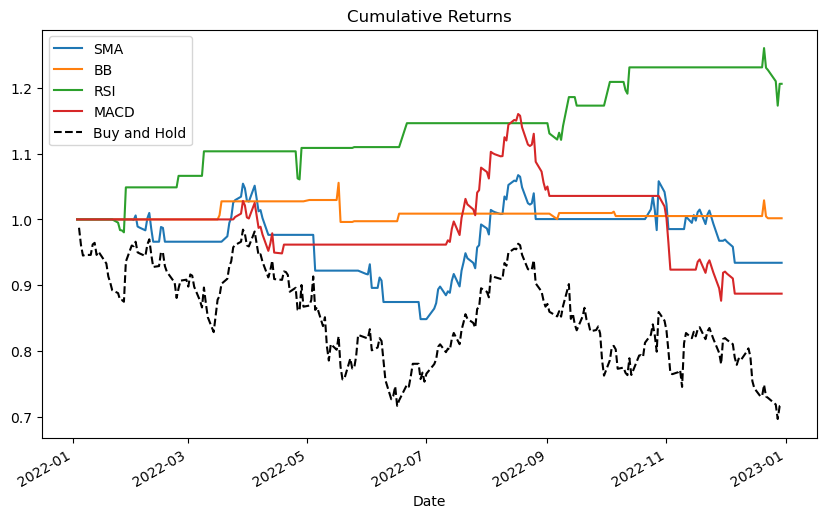

In [4]:
# Example: Run the strategy for Apple (AAPL) from 2022-01-01 to 2023-01-01
run_strategy(ticker='AAPL', start_date='2022-01-01', end_date='2023-01-01')